# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\hp\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#  [2] Exploratory Data Analysis

We already done EDA and prepossing of data and stored it in final.sqlite. This we will use it directly so now we don't need to do EDA and preprocessing. In Preprocessing section, we are going to use our saved final.sqlite directly.

#  [3] Preprocessing

In [2]:
#loading preprocessed data which was stored in final dataset
con = sqlite3.connect('final.sqlite') 

In [3]:
cleaned_data = pd.read_sql_query("select * from Reviews", con)
cleaned_data.shape

(364171, 12)

In [4]:
cleaned_data.head(3)

index      Id   ProductId          UserId            ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL        shari zychinski   
1  138688  150506  0006641040  A2IW4PEEKO2R0U                  Tracy   
2  138689  150507  0006641040  A1S4A3IQ2MU7V4  sally sue "sally sue"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     0                       0      1   939340800   
1                     1                       1      1  1194739200   
2                     1                       1      1  1191456000   

                                      Summary  \
0                   EVERY book is educational   
1  Love the book, miss the hard cover version   
2               chicken soup with rice months   

                                                Text  \
0  this witty little book makes my son laugh at l...   
1  I grew up reading these Sendak books, and watc...   
2  This is a fun way for children to learn their ...   

                                         CleanedText  
0  b'witti littl book make son laugh loud recit c...  
1  b'grew read sendak book watch realli rosi movi...  
2  b'fun way children learn month year learn poem...

In [5]:
cleaned_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [7]:
# To randomly sample 50k points from both class
random_sample_data = cleaned_data.sample(n=50000) 
random_sample_data.shape

(50000, 12)

In [8]:
# Sort data based on time
final_sorted_time=random_sample_data.sort_values('Time',ascending=True,axis=0)
final_sorted_time.head(3)

index      Id   ProductId          UserId               ProfileName  \
0    138706  150524  0006641040   ACITT7DI6IDDL           shari zychinski   
423  417838  451855  B00004CXX9   AJH6LUC1UT1ON  The Phantom of the Opera   
325  346094  374400  B00004CI84  A2DEE7F9XKP3ZR                    jerome   

     HelpfulnessNumerator  HelpfulnessDenominator  Score       Time  \
0                       0                       0      1  939340800   
423                     0                       0      1  946857600   
325                     0                       3      1  959990400   

                                           Summary  \
0                        EVERY book is educational   
423                                     FANTASTIC!   
325  Research - Beatlejuice video - French version   

                                                  Text  \
0    this witty little book makes my son laugh at l...   
423  Beetlejuice is an excellent and funny movie. K...   
325  I'm getting crazy.I'm looking for Beatlejuice ...   

                                           CleanedText  
0    b'witti littl book make son laugh loud recit c...  
423  b'beetlejuic excel funni movi keaton hilari wa...  
325  b'get crazi look beatlejuic french version vid...

In [9]:
text=final_sorted_time['CleanedText'][0:50000]
text.shape

(50000,)

# [4] Featurization

## [4.1] BAG OF WORDS

In [14]:
count_vect = CountVectorizer(min_df = 100) 
data_bow = count_vect.fit_transform(text)

In [15]:
data_bow.shape

(50000, 1855)

## [4.3] TF-IDF

In [16]:
tf_idf_vect = TfidfVectorizer(min_df=100)
data_tf = tf_idf_vect.fit_transform(text)

In [17]:
data_tf.shape

(50000, 1855)

## [4.4] Word2Vec

In [18]:
list_of_sent = []
for i in text:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent.append(sent)

In [19]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent,min_count = 5,size = 50,workers = 4)

In [20]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9322
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'beetlejuic', 'excel', 'funni', 'movi', 'keaton', 'hilari', 'wacki', 'great', 'special', 'effect', 'help', 'film', 'think', 'one', 'best', 'ever', 'made', 'sure', 'youll', 'agre', 'good', 'time']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [21]:
sent_vectors = []
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    
    sent_vectors.append(sent_vec)
print(len(sent_vectors))

50000


In [23]:
data_avgw2v= np.array(sent_vectors)
data_avgw2v.shape

(50000, 50)

#### [4.4.1.2] TFIDF weighted W2v

In [25]:
tf_idf_feat= tf_idf_vect.get_feature_names()

tfidf_sent_vec = []
row = 0
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_train[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    
    tfidf_sent_vec.append(sent_vec)
    row += 1

In [26]:
data_tfw2v= np.array(tfidf_sent_vec)
data_tfw2v.shape

(50000, 50)

# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [27]:
from sklearn.cluster import KMeans
k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    clf_bow = KMeans(n_clusters=i, n_jobs=-1)
    clf_bow.fit(data_bow)
    kmeans=clf_bow.inertia_
    loss.append(kmeans)

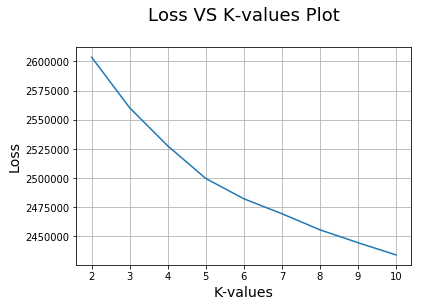

In [28]:
# Draw Loss VS K values plot
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

From above graph, best value of K is 5.

In [33]:
# Implementing K-Means++ using optimal value of K
model_bow= KMeans(n_clusters=5, n_jobs=-1)
p=model_bow.fit(data_bow)

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [101]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    
    
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [99]:
cloud_bow = text.values

In [100]:
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(p.labels_.shape[0]):
    if p.labels_[i] == 0:
        cluster1.append(cloud_bow[i])
    elif p.labels_[i] == 1:
        cluster2.append(cloud_bow[i])
    elif p.labels_[i] == 2:
        cluster3.append(cloud_bow[i])
    elif p.labels_[i] == 3:
        cluster4.append(cloud_bow[i])
    else :
        cluster5.append(cloud_bow[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))        

No. of reviews in Cluster-1 :  6168

No. of reviews in Cluster-2 :  39857

No. of reviews in Cluster-3 :  1078

No. of reviews in Cluster-4 :  1179

No. of reviews in Cluster-5 :  1718


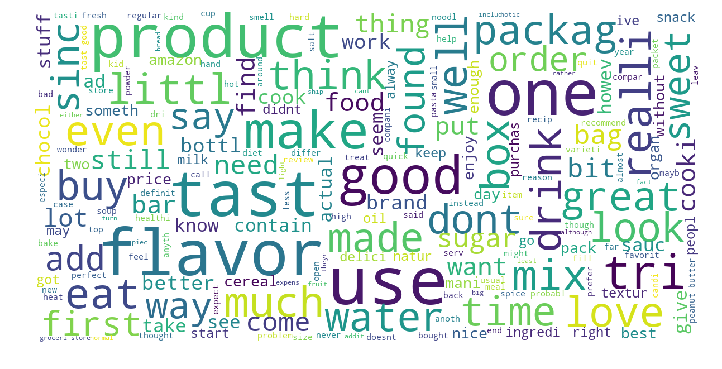

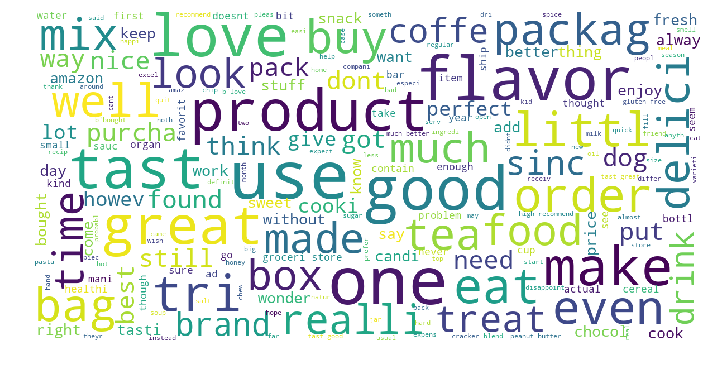

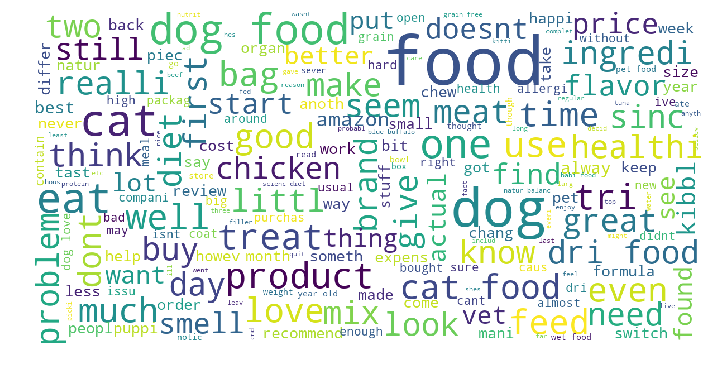

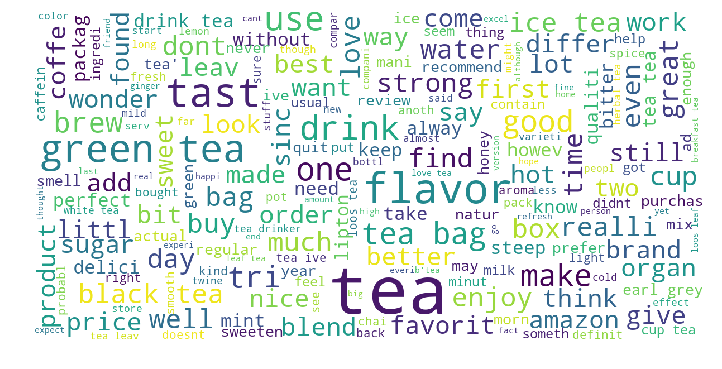

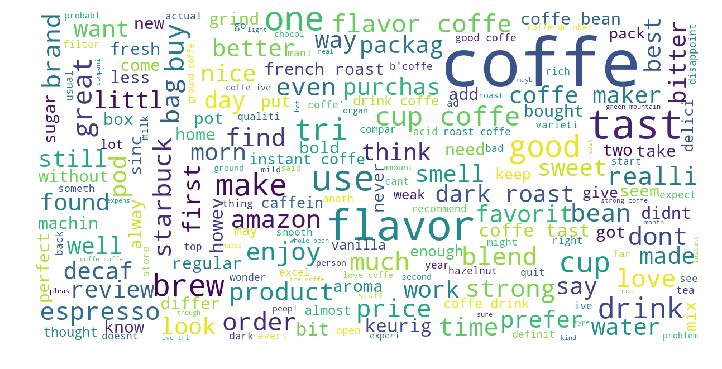

In [102]:
show_wordcloud(cluster1)
show_wordcloud(cluster2)
show_wordcloud(cluster3)
show_wordcloud(cluster4)
show_wordcloud(cluster5)

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [50]:
k_values = [2,3,4,5,6,7,8,9,10]
loss_tf = []
for i in k_values:
    clf_tf = KMeans(n_clusters=i, n_jobs=-1).fit(data_tf)
    kmeans_tf=clf_tf.inertia_
    loss_tf.append(kmeans_tf)

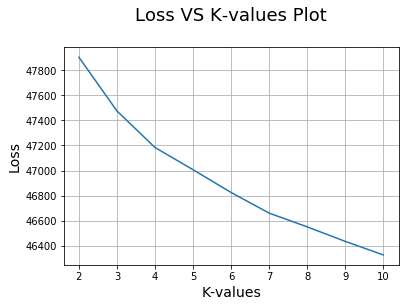

In [51]:
# Draw Loss VS K values plot
plt.plot(k_values, loss_tf)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

From above graph, best value of K is 5.

In [52]:
# Implementing K-Means++ using optimal value of K
model_tf= KMeans(n_clusters=5, n_jobs=-1).fit(data_tf)

In [60]:
text1=text.values

In [61]:
text1.shape

(50000,)

In [63]:
text.head(2)

0      b'witti littl book make son laugh loud recit c...
423    b'beetlejuic excel funni movi keaton hilari wa...
Name: CleanedText, dtype: object

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

In [64]:
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(model_tf.labels_.shape[0]):
    if model_tf.labels_[i] == 0:
        cluster1.append(text1[i])
    elif model_tf.labels_[i] == 1:
        cluster2.append(text1[i])
    elif model_tf.labels_[i] == 2:
        cluster3.append(text1[i])
    elif model_tf.labels_[i] == 3:
        cluster4.append(text1[i])
    else :
        cluster5.append(text1[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))   

No. of reviews in Cluster-1 :  25046

No. of reviews in Cluster-2 :  3300

No. of reviews in Cluster-3 :  4159

No. of reviews in Cluster-4 :  13449

No. of reviews in Cluster-5 :  4046


In [94]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    
    
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

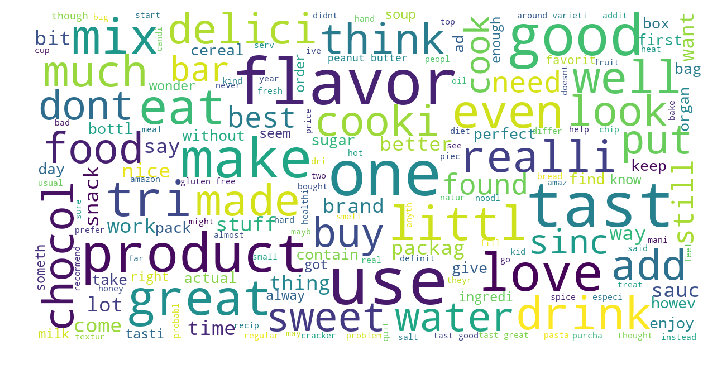

In [96]:
#names_tf = tf_idf_vect.get_feature_names() 
show_wordcloud(cluster1)

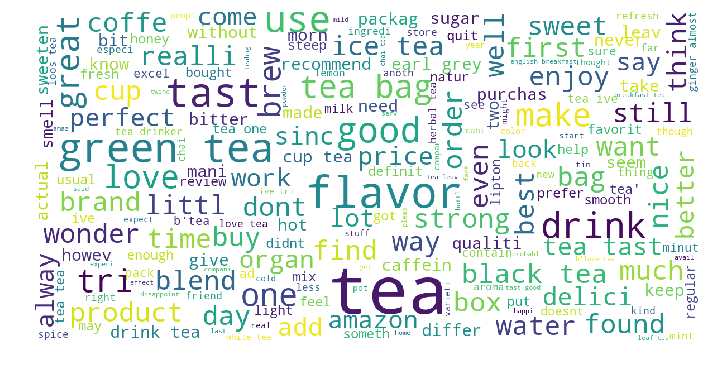

In [97]:
show_wordcloud(cluster2)

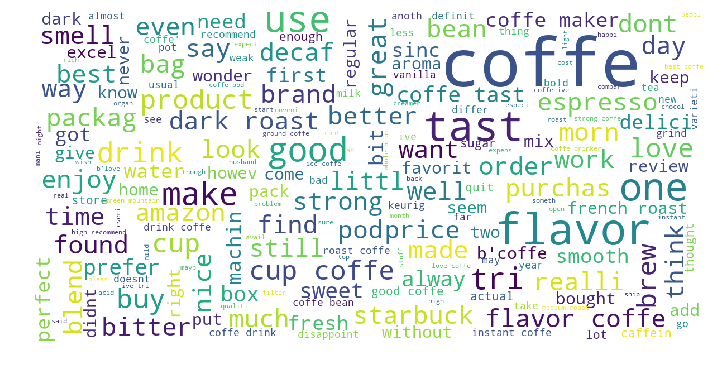

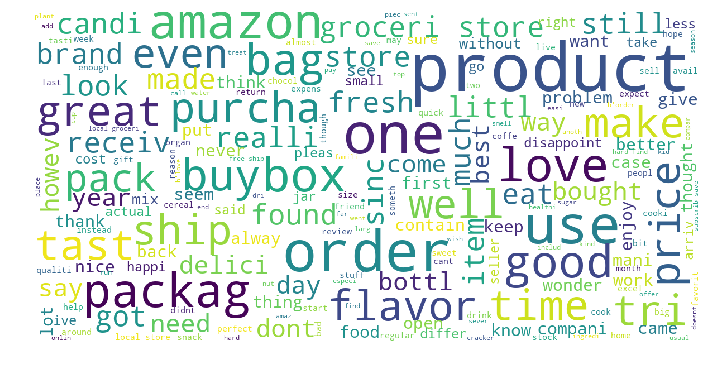

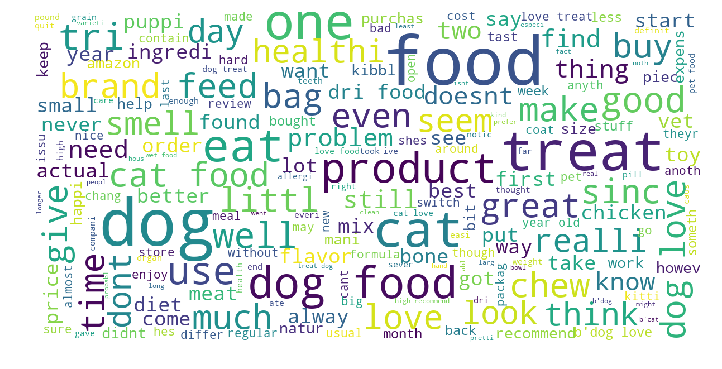

In [98]:
show_wordcloud(cluster3)
show_wordcloud(cluster4)
show_wordcloud(cluster5)

In [89]:
# Three Reviews of cluster 1
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    count +=1

Review-1 : 
 b'witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg'

Review-2 : 
 b'beetlejuic excel funni movi keaton hilari wacki beetlejuic great special effect help film think one best movi ever made sure youll agre good time watch beetlejuic'

Review-3 : 
 b'much easier use wilson past color color vibrant taint frost like color simpl use make mess complaint find year ago must decor often'



In [90]:
# Three Reviews of cluster 2
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    count +=1

Review-1 : 
 b'think great chai far sweet found unsweet exact like tiger spice great blend black tea cinnamon ginger herb big tea drinker smooth light chai add water come creami perfect peopl add milk chai mix alreadi creamer new healthi breakfast wake great mani indian friend drink fresh made chai close come instant blend high recommend'

Review-2 : 
 b'recent order hot cinnamon spice tea harney son tea tast like hot cinnamon candi often use decor cooki valentin day tea sweet yet spici accord harney literatur tea contain sugar tast tea insist sugar think sweet tast come sweet clove use within tea aroma wonder moment tea open must say high impress tea tea avail loos bag'

Review-3 : 
 b'exquisit black tea littl extra your fond black tea think earl grey bit twee give one tri flavor aroma brisk refin becom standard'



In [91]:
# Three Reviews of cluster 2
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    count +=1

Review-1 : 
 b'youv never tri kona coffe aloha island definit one start kona coffe grown kona district big island regard best coffe world coffe aficionado mean tast differ kona coffe full rich almost alway reserv kona lazi weekend brunch serv dessert love dinner aloha island oper qualiti manag program kona coffe certifi kona mean your guarante get qualiti kona coffe order keep mind aloha island three grade kona coffe sell gold platinum diamond suppos privat reserv obvious get expens ladder gold good great place start sampl fare'

Review-2 : 
 b'real deal peopl real jamaican coffe brand claim blue mountain authent tast wife jamaican jamaica time never seem bring back enough coffe set find brand state would atleast close get jamiaca wow flavor'

Review-3 : 
 b'drink coffe well twenti year final found bean suit tast bud grind coffe tri whole bean dark roast best year kona coffe lover end road also made coffe standard offic'



In [92]:
# Three Reviews of cluster 2
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    count +=1

Review-1 : 
 b'get crazi look beatlejuic french version video realli imposs today find french vhs version film could pleas tell someth tks'

Review-2 : 
 b'get crazi realli imposs today find french vhs version film could pleas tell someth tks'

Review-3 : 
 b'year tri simul truli italian espresso cappuccino without success sever packag arriv christma son sent briel cadiz espresso machin two love russian china cup case espression classic espresso pod kindest wonder christma present rememb espresso machin excel qualiti eas use espresso exquisit time prepar espresso cappuccino experi son love kind small part mani gift itali heaven earth'



In [93]:
# Three Reviews of cluster 2
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster5[i]))
    count +=1

Review-1 : 
 b'think live better job varieti friski say cat friski doesnt look fresh appet live cat doesnt like well smell nasti look quit good live think could definit better varieti even add chees cat leav one dish eat live version'

Review-2 : 
 b'get toothbrush kit cat bad gene pool regard teeth work great cat doesnt realli seem mind teeth brush pay clean definit good invest cat bad teeth even doesnt good habit start cat hygien definit save health bill later'

Review-3 : 
 b'look smell like human cooki keep away children dog upset'



### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [103]:
k_values = [2,3,4,5,6,7,8,9,10]
loss_avgw2v = []
for i in k_values:
    clf_avgw2v = KMeans(n_clusters=i, n_jobs=-1).fit(data_avgw2v)
    kmeans_avgw2v=clf_avgw2v.inertia_
    loss_avgw2v.append(kmeans_avgw2v)

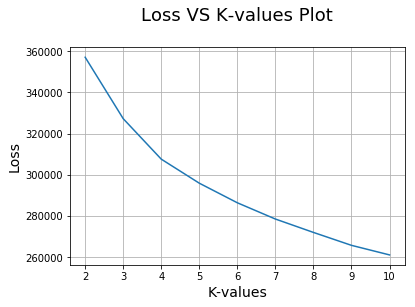

In [105]:
# Draw Loss VS K values plot
plt.plot(k_values, loss_avgw2v)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

From above graph, best value of K is 4.

In [106]:
# Implementing K-Means++ using optimal value of K
model_avgw2v= KMeans(n_clusters=4, n_jobs=-1).fit(data_avgw2v)

In [107]:
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

for i in range(model_avgw2v.labels_.shape[0]):
    if model_avgw2v.labels_[i] == 0:
        cluster1.append(text1[i])
    elif model_avgw2v.labels_[i] == 1:
        cluster2.append(text1[i])
    elif model_avgw2v.labels_[i] == 2:
        cluster3.append(text1[i])
    else:
        cluster4.append(text1[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

No. of reviews in Cluster-1 :  20534

No. of reviews in Cluster-2 :  7780

No. of reviews in Cluster-3 :  8556

No. of reviews in Cluster-4 :  13130


### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

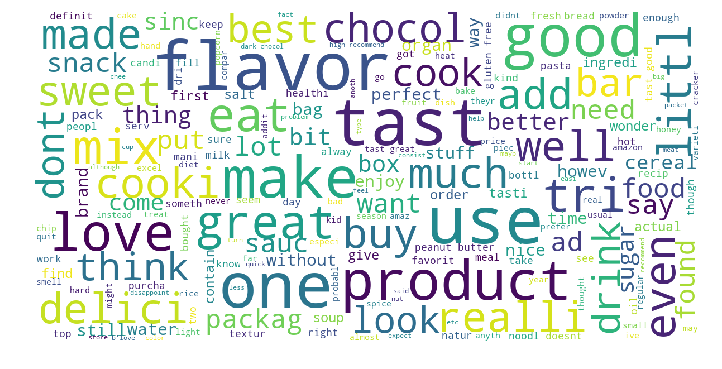

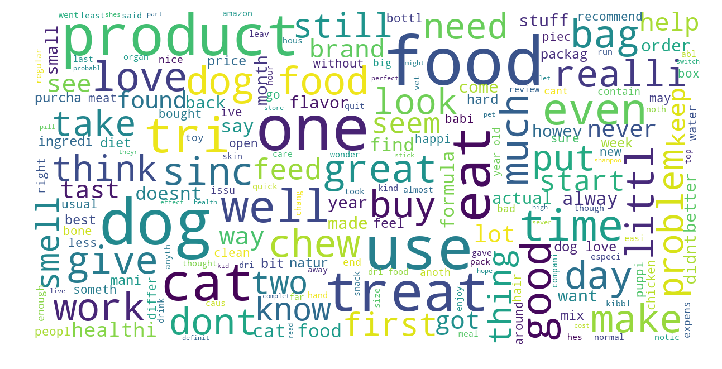

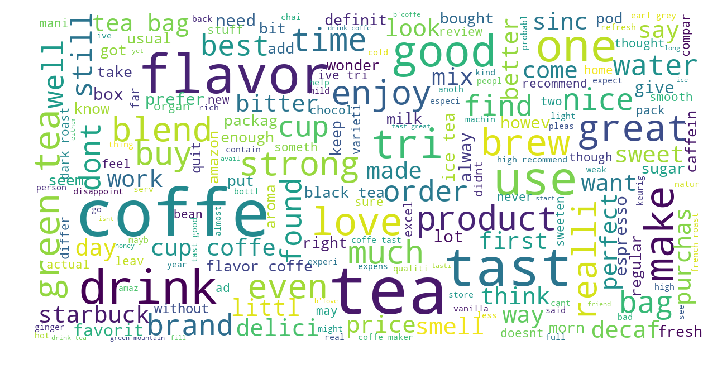

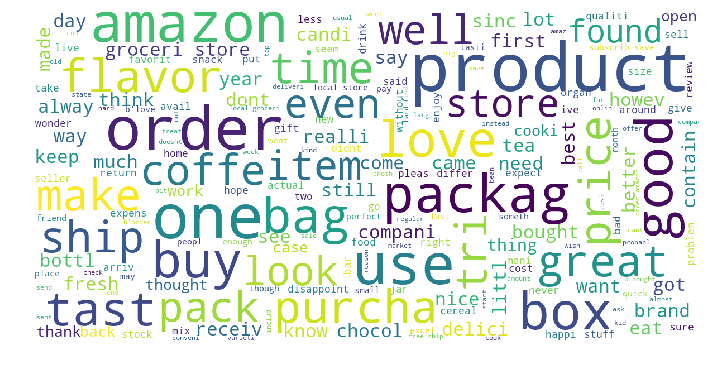

In [108]:
show_wordcloud(cluster1)
show_wordcloud(cluster2)
show_wordcloud(cluster3)
show_wordcloud(cluster4)

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [104]:
k_values = [2,3,4,5,6,7,8,9,10]
loss_tfw2v = []
for i in k_values:
    clf_tfw2v = KMeans(n_clusters=i, n_jobs=-1).fit(data_tfw2v)
    kmeans_tfw2v=clf_tfw2v.inertia_
    loss_tfw2v.append(kmeans_tfw2v)

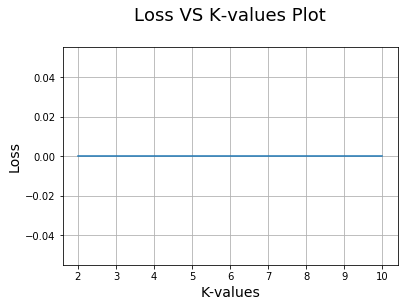

In [110]:
# Draw Loss VS K values plot
plt.plot(k_values, loss_tfw2v)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

In [111]:
# Implementing K-Means++ using optimal value of K
model_tfw2v= KMeans(n_clusters=4, n_jobs=-1).fit(data_tfw2v)

In [112]:
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

for i in range(model_tfw2v.labels_.shape[0]):
    if model_tfw2v.labels_[i] == 0:
        cluster1.append(text1[i])
    elif model_tfw2v.labels_[i] == 1:
        cluster2.append(text1[i])
    elif model_tfw2v.labels_[i] == 2:
        cluster3.append(text1[i])
    else:
        cluster4.append(text1[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

No. of reviews in Cluster-1 :  50000

No. of reviews in Cluster-2 :  0

No. of reviews in Cluster-3 :  0

No. of reviews in Cluster-4 :  0


### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

No. of review contains only in cluster1 and other all remaining 3 cluster doesnt have any reviews.

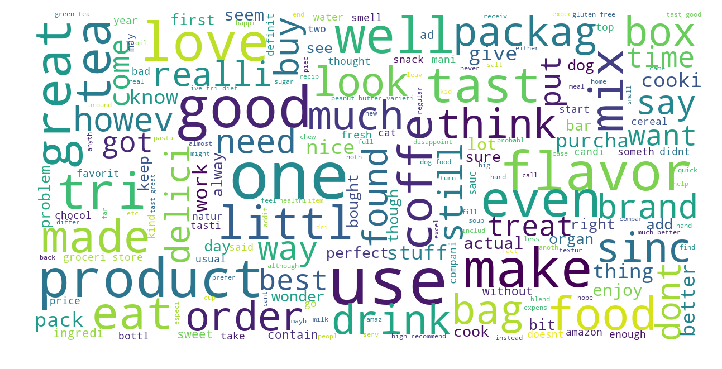

In [114]:
show_wordcloud(cluster1)

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [115]:
data_avgw2v.shape

(50000, 50)

In [116]:
data_w2v=data_avgw2v[0:2000]
data_w2v.shape

(2000, 50)

#### Agglomerative Clustering with 2 cluster

In [117]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=2).fit(data_w2v)

In [118]:
text_agg=text[0:2000].values
text_agg.shape

(2000,)

In [119]:
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(text_agg[i])
    else :
        cluster2.append(text_agg[i])
         
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  1701

No. of reviews in Cluster-2 :  299


### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering with 2 cluster on AVG W2V<font color='red'> SET 3</font>

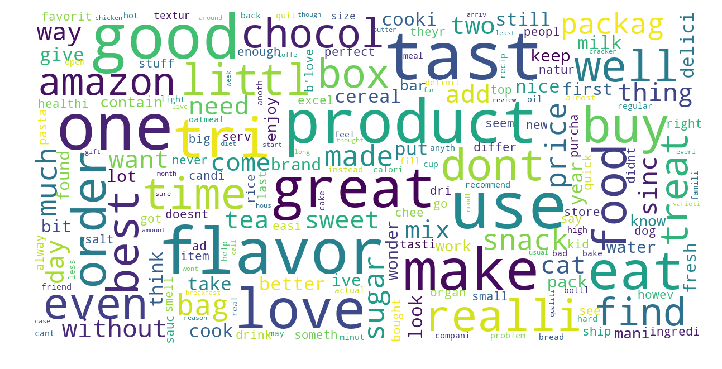

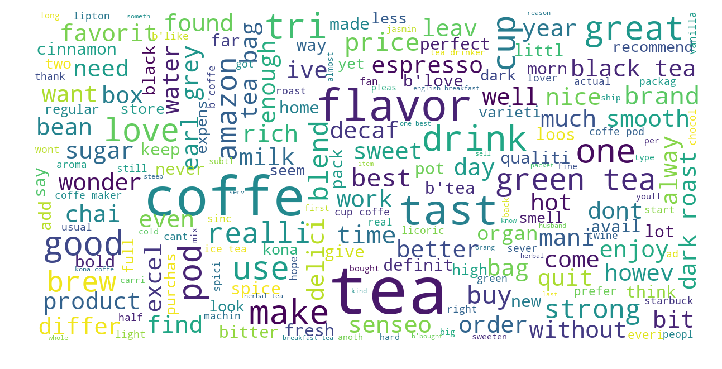

In [120]:
show_wordcloud(cluster1)
show_wordcloud(cluster2)

### Agglomerative Clustering with 5 cluster

In [122]:
model = AgglomerativeClustering(n_clusters=5).fit(data_w2v)

In [124]:
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(text_agg[i])
    elif model.labels_[i] == 1:
        cluster2.append(text_agg[i])
    elif model.labels_[i] == 2:
        cluster3.append(text_agg[i])
    elif model.labels_[i] == 3:
        cluster4.append(text_agg[i])
    else :
        cluster5.append(text_agg[i])
         
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))

No. of reviews in Cluster-1 :  566

No. of reviews in Cluster-2 :  347

No. of reviews in Cluster-3 :  361

No. of reviews in Cluster-4 :  299

No. of reviews in Cluster-5 :  427


### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering with 5 cluster on AVG W2V<font color='red'> SET 3</font>

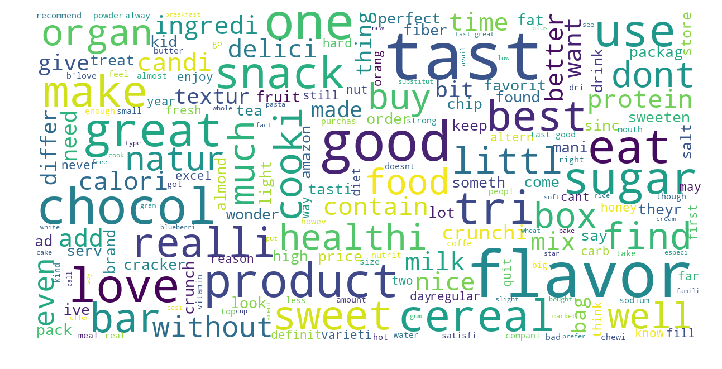

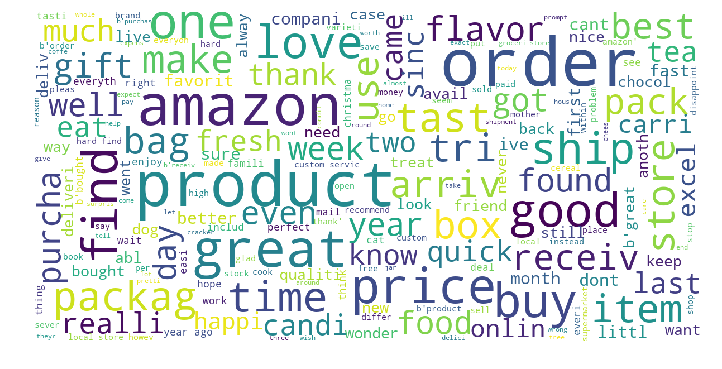

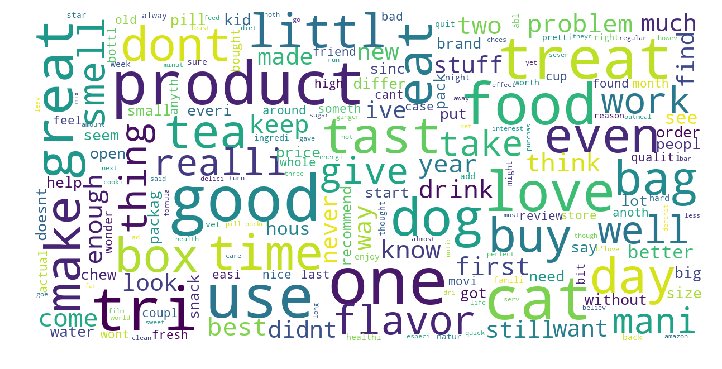

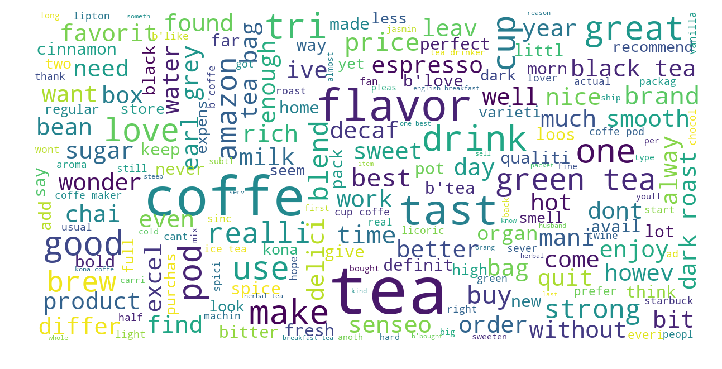

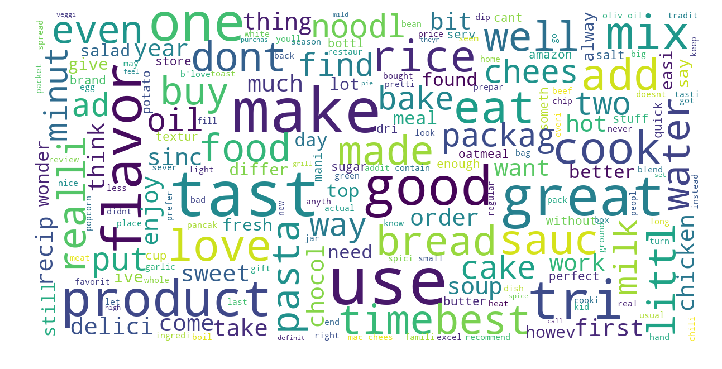

In [125]:
show_wordcloud(cluster1)
show_wordcloud(cluster2)
show_wordcloud(cluster3)
show_wordcloud(cluster4)
show_wordcloud(cluster5)

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [121]:
data_set4=data_tfw2v[0:2000]
data_set4.shape

(2000, 50)

### Applying Agglomerative Clustering with 2 cluster

In [126]:
model = AgglomerativeClustering(n_clusters=2).fit(data_set4)

In [127]:
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(text_agg[i])
    else :
        cluster2.append(text_agg[i])
         
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  1999

No. of reviews in Cluster-2 :  1


#### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering with 2 cluster on TFIDF W2V<font color='red'> SET 4</font>

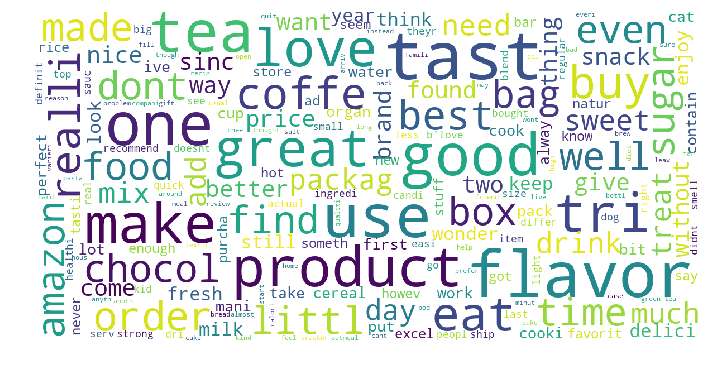

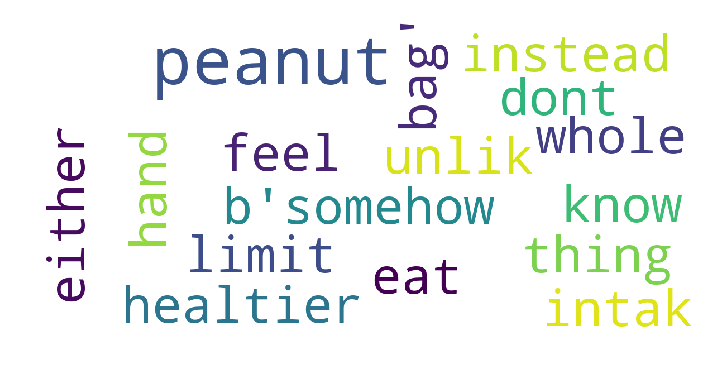

In [128]:
show_wordcloud(cluster1)
show_wordcloud(cluster2)

### Applying Agglomerative Clustering with 5 cluster

In [129]:
model = AgglomerativeClustering(n_clusters=5).fit(data_set4)

In [130]:
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(text_agg[i])
    elif model.labels_[i] == 1:
        cluster2.append(text_agg[i])
    elif model.labels_[i] == 2:
        cluster3.append(text_agg[i])
    elif model.labels_[i] == 3:
        cluster4.append(text_agg[i])
    else :
        cluster5.append(text_agg[i])
         
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))

No. of reviews in Cluster-1 :  1996

No. of reviews in Cluster-2 :  1

No. of reviews in Cluster-3 :  1

No. of reviews in Cluster-4 :  1

No. of reviews in Cluster-5 :  1


### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering with 5 cluster on TFIDF W2V<font color='red'> SET 4</font>

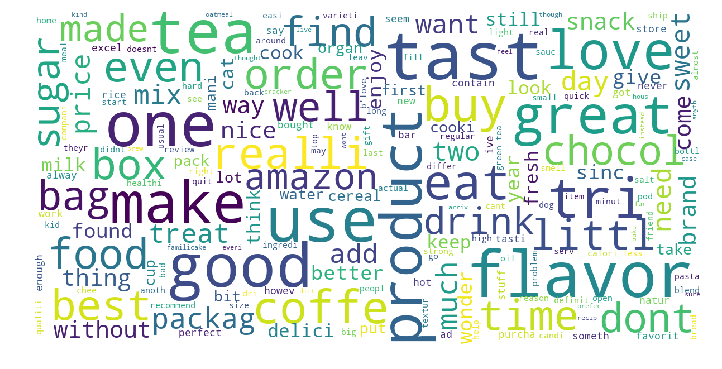

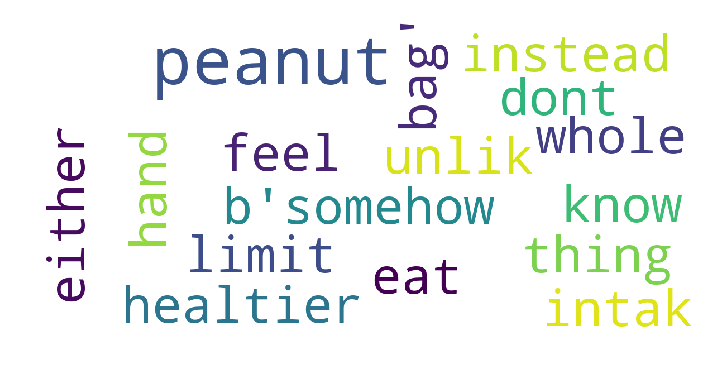

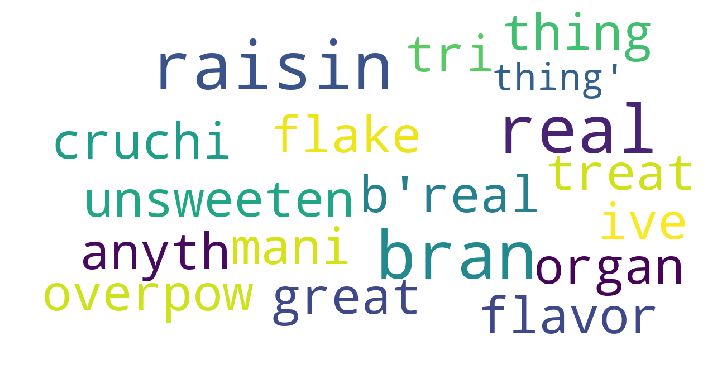

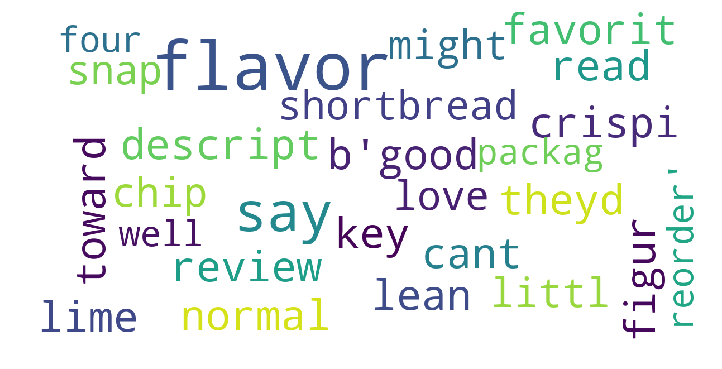

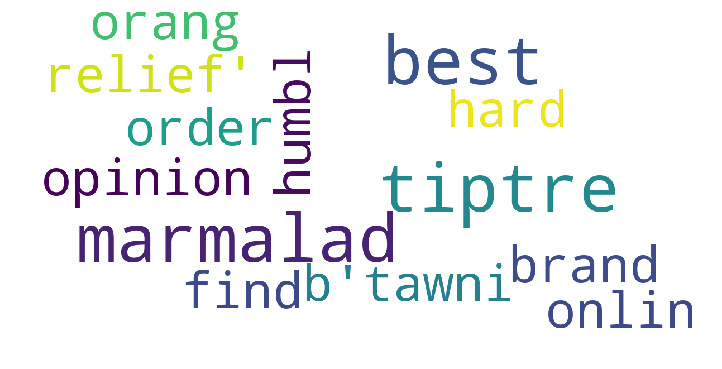

In [131]:
show_wordcloud(cluster1)
show_wordcloud(cluster2)
show_wordcloud(cluster3)
show_wordcloud(cluster4)
show_wordcloud(cluster5)

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

Function to call DBSCAN as follows:

In [133]:
# Function definition for implementing DBSCAN
def dbscan(epsilon, samples, Data):
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps=epsilon, min_samples=samples, n_jobs=-1).fit(Data)
    
    # Number of clusters in labels, ignoring noise(-1) if present.
    n_clusters = len(set(db.labels_))
    print("Number of clusters for MinPts = %d and Epsilon = %f is : %d "%(samples,epsilon,n_clusters))
    print("Labels(-1 is for Noise) : ",set(db.labels_))
    print()
    return db

Function To Compute Distance of nth-nearest neighbour as follows:

In [134]:
# function to determinethe distance of nth-nearest neighbour to all points in a multi-dimensional array
def n_neighbour(vectors , n):
    distance = []
    for point in vectors:
        temp = np.sort(np.sum((vectors-point)**2,axis=1),axis=None)
        distance.append(temp[n])
    return np.sqrt(np.array(distance))  

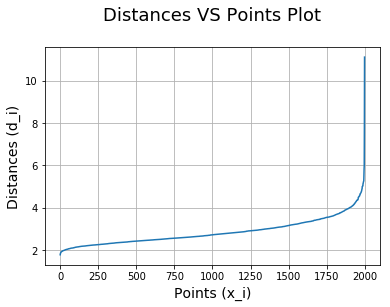

In [135]:
min_points = 2*data_w2v.shape[1]

# Computing distances of nth-nearest neighbours
distances = n_neighbour(data_w2v,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(data_w2v.shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

From above graph, we can see that the optimal value of Epsilon is 4 because after that there is sharp rise in the value of distances (d_i's)

### DBSCAN implementation 

In [136]:
optimal_eps = 4
# Clustering with right epsilon
db1 = dbscan(optimal_eps, min_points, data_w2v)


# Clustering with  epsilon = 5
db2 = dbscan(5, min_points, data_w2v)


# Clustering with epsilon = 6
db3 = dbscan(6, min_points, data_w2v)


# Clustering with epsilon = 7
db4 = dbscan(7, min_points, data_w2v)

Number of clusters for MinPts = 100 and Epsilon = 4.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 100 and Epsilon = 5.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 100 and Epsilon = 6.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}

Number of clusters for MinPts = 100 and Epsilon = 7.000000 is : 2 
Labels(-1 is for Noise) :  {0, -1}



In [137]:
X_corpus=text[0:2000]

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

In [140]:
#This function is used to plot a word cloud given a text corpus.
def plot_word_clouds_db(review_corpus,cluster_name):
    wordcloud = WordCloud(width=800, height=450, margin=2, max_font_size=50, scale=1, max_words=100, 
                          random_state=42, background_color='black', repeat=False).generate(str(review_corpus))
    plt.figure(figsize=(16,9))
    if cluster_name == -1:
        plt.title("Word Cloud for Cluster {} (Noisy Cluster)".format(cluster_name))
    else:
        plt.title("Word Cloud for Cluster {} (Dense Cluster)".format(cluster_name+1))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show() 

In [141]:
def draw_word_clouds_clusters_db(model, X_corpus):
    reviews=list(X_corpus)
    labels=model.labels_ #Labels of each data point
    clusters_list=list(set(labels)) #List of all unique clusters
    no_of_clusters = len(set(labels)) #Total number of clusters obtained.
    
    for cluster_name in clusters_list:
        cluster_reviews = []
        review_count = 1      
        for i in range(labels.shape[0]):
            if (labels[i] == cluster_name):
                cluster_reviews.append(reviews[i])
        plot_word_clouds_db(cluster_reviews,cluster_name)

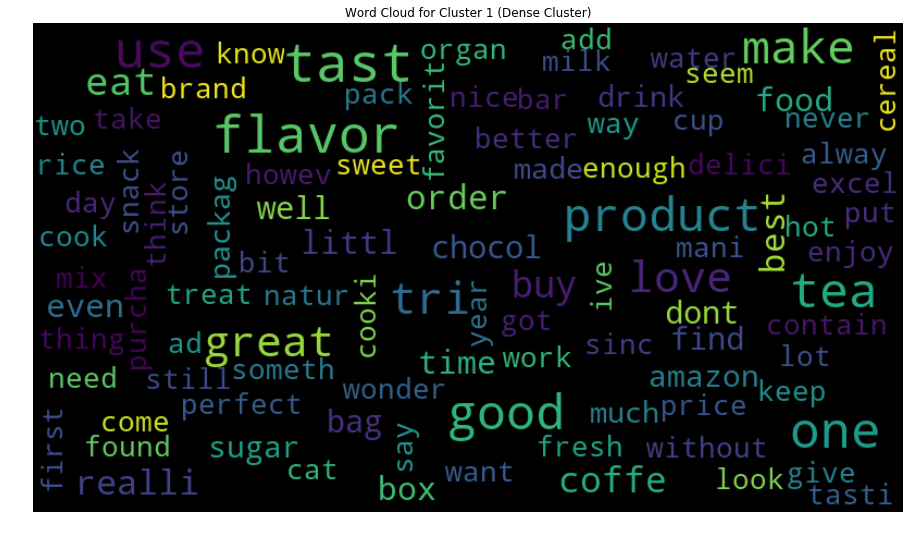

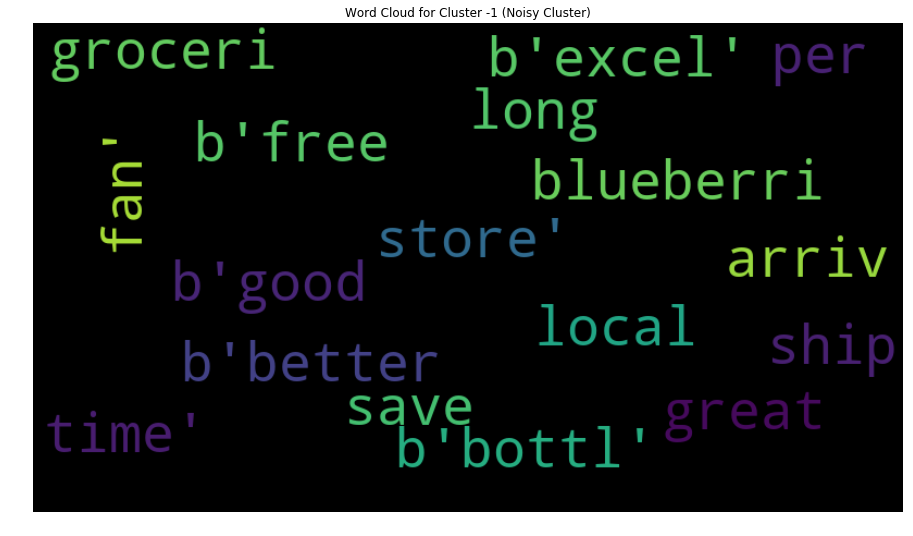

In [142]:
draw_word_clouds_clusters_db(db1, X_corpus)

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [143]:
data_set4.shape

(2000, 50)

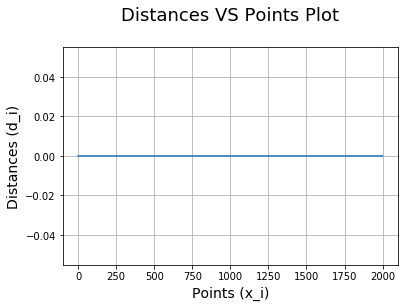

In [144]:
min_points = 2*data_set4.shape[1]

# Computing distances of nth-nearest neighbours
distances = n_neighbour(data_set4,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(data_set4.shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

### DBSCAN implementation on tfidf w2v

In [145]:
optimal_eps = 4
# Clustering with right epsilon
db1 = dbscan(optimal_eps, min_points, data_set4)


# Clustering with  epsilon = 5
db2 = dbscan(5, min_points, data_set4)


# Clustering with epsilon = 6
db3 = dbscan(6, min_points, data_set4)


# Clustering with epsilon = 7
db4 = dbscan(7, min_points, data_set4)

Number of clusters for MinPts = 100 and Epsilon = 4.000000 is : 1 
Labels(-1 is for Noise) :  {0}

Number of clusters for MinPts = 100 and Epsilon = 5.000000 is : 1 
Labels(-1 is for Noise) :  {0}

Number of clusters for MinPts = 100 and Epsilon = 6.000000 is : 1 
Labels(-1 is for Noise) :  {0}

Number of clusters for MinPts = 100 and Epsilon = 7.000000 is : 1 
Labels(-1 is for Noise) :  {0}



### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

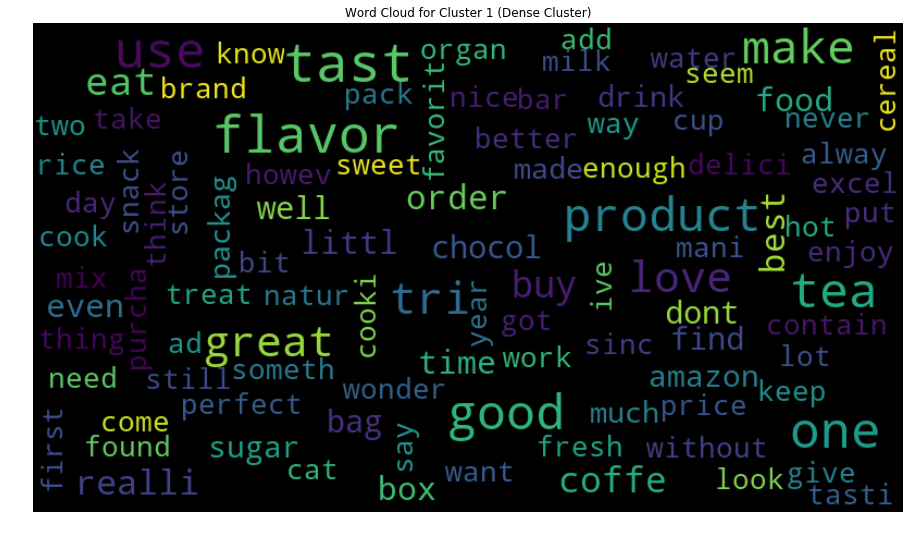

In [146]:
draw_word_clouds_clusters_db(db1, X_corpus)

# Conclusion

In [150]:
from prettytable import PrettyTable
ptable1 = PrettyTable()

vec1 = "BOW"
vec2 = "TFIDF"
vec3 = "AVG-W2V"
vec4 = "TFIDF-W2V"

model1 = 'Kmeans Clustering'
model2 = 'Agglomerative clustering'
model3= 'DBSCAN Clustering'


ptable1.field_names = ["Vectorizer","Model","Optimal_Cluster"]
ptable1.add_row([vec1,model1,5])
ptable1.add_row([vec2,model1,5])
ptable1.add_row([vec3,model1,4])
ptable1.add_row([vec4,model1,1])
print(ptable1)

ptable2 = PrettyTable()
ptable2.field_names = ["Vectorizer","Model","Optimal_Cluster"]
ptable2.add_row([vec3,model2,2])
ptable2.add_row([vec3,model2,5])
ptable2.add_row([vec4,model2,2])
ptable2.add_row([vec4,model2,5])
print(ptable2)

ptable3 = PrettyTable()
ptable3.field_names = ["Vectorizer","Model","Min-pts","Eps"]
ptable3.add_row([vec3,model3,100,4])
ptable3.add_row([vec4,model3,100,1])
print(ptable3)

+------------+-------------------+-----------------+
| Vectorizer |       Model       | Optimal_Cluster |
+------------+-------------------+-----------------+
|    BOW     | Kmeans Clustering |        5        |
|   TFIDF    | Kmeans Clustering |        5        |
|  AVG-W2V   | Kmeans Clustering |        4        |
| TFIDF-W2V  | Kmeans Clustering |        1        |
+------------+-------------------+-----------------+
+------------+--------------------------+-----------------+
| Vectorizer |          Model           | Optimal_Cluster |
+------------+--------------------------+-----------------+
|  AVG-W2V   | Agglomerative clustering |        2        |
|  AVG-W2V   | Agglomerative clustering |        5        |
| TFIDF-W2V  | Agglomerative clustering |        2        |
| TFIDF-W2V  | Agglomerative clustering |        5        |
+------------+--------------------------+-----------------+
+------------+-------------------+---------+-----+
| Vectorizer |       Model       | Min-pts | 